# Analysis of Shopee reviews
**Objectives**
1. Enable consumers to quickly extract the key topics covered by the reviews without having to go through all of them
2. Help the sellers/retailers get consumer feedback in the form of topics (extracted from the consumer reviews)

### Import libraries
Python packages descriptions:

- pandas is data manipulation tool
- numpy is a package for scientific computing
- sklearn is a machine learning library
- vaderSentiment is a rule-based sentiment analysis tool
- spacy is a natural language processing library
- nltk is a natural language processing library

In [1]:
!pip install vaderSentiment

In [2]:
!pip install wordcloud

In [3]:
# Data Analysis and Wrangling
import numpy as np
import pandas as pd

# machine learning
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#NLP
import spacy
import nltk
from nltk.corpus import stopwords

import re

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

#Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# library for LDA visualization
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from argparse import Namespace
import warnings
warnings.filterwarnings("ignore")

In [4]:
flags = Namespace(
    input_file='productReviewShopee_1.csv',
    output_file='productReviewShopee_1_sentiment.csv',
    topic_file_name = 'Topics_Visualization_',
    n_categories=5,
    pos_filter = ['NOUN', 'VERB', 'ADJ', 'ADV']
)

### Libraries version

In [5]:
import sys
print('The python version is {}.'.format(sys.version))
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The spacy version is {}.'.format(spacy.__version__))
print('The nltk version is {}.'.format(nltk.__version__))

The python version is 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)].
The numpy version is 1.16.4.
The pandas version is 0.24.2.
The scikit-learn version is 0.20.3.
The spacy version is 2.0.12.
The nltk version is 3.4.1.


### Load Data
Read training dataset into Pandas Dataframe using python pandas packages

In [6]:
df = pd.read_csv(flags.input_file)

In [7]:
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (11416, 6)


In [8]:
df.head(5)

title  rating        date categorie  \
0  🔥 Mini shoulder bag (M-688)       4  2019-05-22       Bag   
1  🔥 Mini shoulder bag (M-688)       5  2019-07-18       Bag   
2  🔥 Mini shoulder bag (M-688)       5  2019-07-02       Bag   
3  🔥 Mini shoulder bag (M-688)       1  2018-12-15       Bag   
4  🔥 Mini shoulder bag (M-688)       1  2019-07-24       Bag   

                                            comments product_option  
0  Give 4 stars because order at the price 37 but...          Pink:  
1  Ordered at a discount of 10 baht per piece. It...          Black  
2  Small, cute, compact, good But the sash looks ...            Tau  
3  The size is not as large as it is down. The st...          Black  
4  The product is compared to the price. Okay. Se...          Black

The data contains the following columns:
- title
- rating
- date
- categorie
- comments
- product_option

For the scope of analysis, the comments column will be used for Topic Modeling

### Natural Language Processing (NLP)

### Pre-processing Data

#### Remove data where comments are Nan

In [9]:
df = df[df['comments'].notnull()]

In [10]:
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (11402, 6)


#### Remove punctuation

In [11]:
df['comments_cleaned'] = df['comments'].apply(lambda x: re.sub(r'[^ \\t\w\.]', '', re.sub(re.compile('{.*?}'), '', x)))

In [12]:
df['comments_cleaned'] = df['comments_cleaned'].apply(lambda x: x.strip())

#### Tokenization, Remove stop words, Lemmatizing, Part-Of-Speech (POS) tagging 
spaCy is an open-source software library for advanced Natural Language Processing

Lemmatization is the process of converting a word to its base form Use NLP spaCy's lemmatizer: parse the sentence using the loaded model object nlp and extract the lemma for each token.

Examples of lemmatization:

- "accessories" to "accessory"
- "receiving" to "receive"
- "forgot" to "forget"

In [13]:
nlp = spacy.load('en', disable=["ner"])

#### Define stop words

In [14]:
stop_en = stopwords.words('english')

In [15]:
custom_stop_words = ["like", "etc"]

In [16]:
stop_en = stop_en + custom_stop_words

In [17]:
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop | token.is_digit 
                | (not token.pos_ in flags.pos_filter))

In [18]:
%%time
df['comments_lemma'] = df['comments_cleaned'].apply(lambda x: ' '.join([token.lemma_.lower() for token in nlp(x) 
                                                            if token_filter(token) & 
                                                            (token.lemma_ != '-PRON-')
                                                            & (not token.text.lower() in stop_en)
                                                            & (not token.lemma_.lower() in stop_en)]))

Wall time: 3min 11s


### Vectorizing Data and Feature Engineering

#### Bag-Of-Words and N-Grams
Each text should be represented as a vector with length equal to the vocabulary size. Each dimension of this vector corresponds to the occurrence of a word in a text.

CountVectorizer from scikit-learn is used to convert a raw text definitions to a matrix of token counts.

TF-IDF should not be used with LDA algorithm because:
- LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. Re-weighting the TF's by its IDF's would dispropotionally increase the chance of rare words being sampled, making them have a stronger influence in topic assignment

In [19]:
tokenized_data = df[df['comments_lemma'] != '']['comments_lemma'].values

- token_pattern: Regular expression denoting what constitutes a “token”. Consider only words with number of chars more than 3
- lowercase: Convert all characters to lowercase before tokenizing
- n-Gram range: the lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.
- max_df: when building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts
- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

In [20]:
tf_vectorizer = CountVectorizer(max_df=0.5, 
                                min_df=15,
                                token_pattern='[a-zA-Z]{3,}',  # num chars > 3
                                lowercase = True,
                                ngram_range=(1,2)
                               )
vector = tf_vectorizer.fit_transform(tokenized_data)

In [21]:
print("Total number of samples: %d; Total number of features: %d" % vector.shape)
print()

Total number of samples: 11207; Total number of features: 808



### Top 50 words distribution in comments
- after removing stop words

In [22]:
tf_vec = CountVectorizer()
tf = tf_vec.fit_transform(tokenized_data)

In [23]:
tf_st = np.sum(tf,axis=0)
t_st = np.squeeze(np.asarray(tf_st))
term_freq_df_st = pd.DataFrame([t_st], columns=tf_vec.get_feature_names()).transpose()
term_freq_df_st.columns = ['Total']
term_freq_df_st.sort_values('Total', inplace=True, ascending = False)
term_freq_df_st = term_freq_df_st.loc[term_freq_df_st.index.str.isalpha()]

Text(0.5, 1.0, 'Top 50 words in comments')

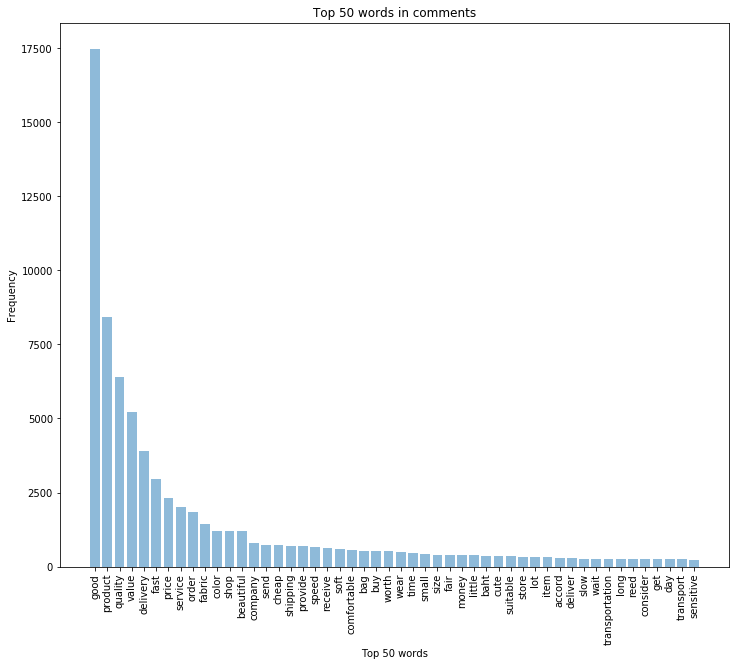

In [24]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df_st.sort_values(by='Total', ascending=False)['Total'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df_st.sort_values(by='Total', ascending=False)['Total'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 words')
plt.title('Top 50 words in comments')

### Top 50 phrases distribution in comments
- after removing stop words

In [25]:
tf_vec_2 = CountVectorizer(ngram_range=(2,2))
tf_2 = tf_vec_2.fit_transform(tokenized_data)

In [26]:
tf_st = np.sum(tf_2,axis=0)
t_st = np.squeeze(np.asarray(tf_st))
term_freq_df_st = pd.DataFrame([t_st], columns=tf_vec_2.get_feature_names()).transpose()
term_freq_df_st.columns = ['Total']
term_freq_df_st.sort_values('Total', inplace=True, ascending = False)

Text(0.5, 1.0, 'Top 50 phrases in comments')

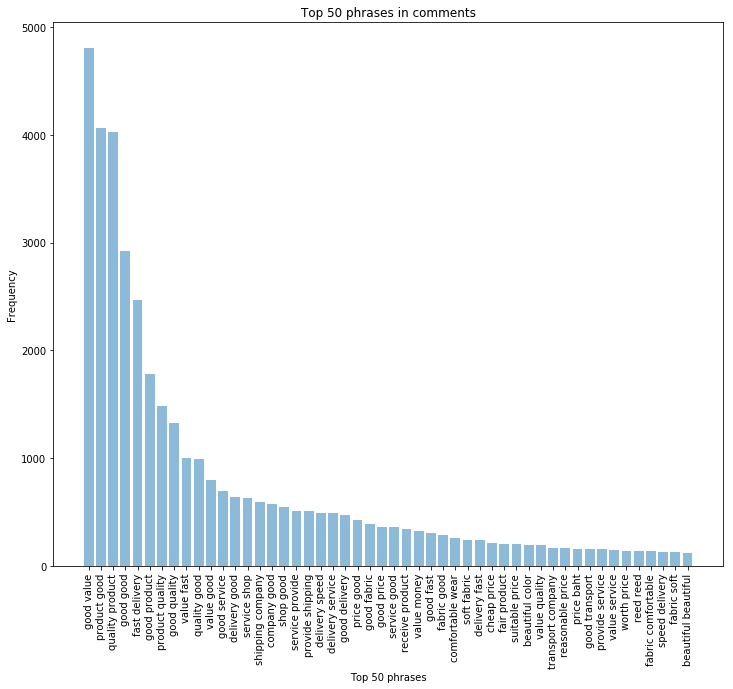

In [27]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df_st.sort_values(by='Total', ascending=False)['Total'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df_st.sort_values(by='Total', ascending=False)['Total'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 phrases')
plt.title('Top 50 phrases in comments')

### Categories distribution

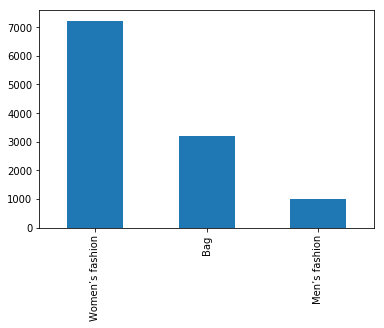

In [28]:
pd.value_counts(df['categorie']).plot(kind="bar")

### Topic Modeling for whole dataset
#### Latent Dirichlet Allocation (LDA) unsupervised algorithm
Topic (category) modeling task is based on Latent Dirichlet Allocation (LDA) algorithm. LDA is generative probabilistic model. The model treats documents as a bag-of-words and attempts to find the structure or topics in this collection. LDA groups definitions based on the words that occur in them. As definitions on similar topics tend to use a similar sub-vocabulary, the resulting clusters of documents can be interpreted as different 'categories'. LDA defines each topic as a bag of words. Every definition will have the probability of belonging to a category.

- Text 1: 100% Category F
- Text 2: 100% Category P
- Text 3: 33% Category P and 67% Category F

Main parameter for LDA model is a number of topics (categories)

In [29]:
lda = LatentDirichletAllocation(n_components=flags.n_categories, 
                                random_state=0, 
                                verbose=True,
                                max_iter=10,
                                batch_size=1000
                               )

In [30]:
%%time
lda.fit(vector)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Wall time: 1min 17s


LatentDirichletAllocation(batch_size=1000, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=True)

#### Top terms in topics in LDA model

In [31]:
# print top words in category 
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [32]:
print("Top words/phrases in each topic")
print()
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 10)

Top words/phrases in each topic

Topic 0: quality, good product, product quality, price, quality good, delivery, speed, good quality, delivery speed, good delivery
Topic 1: order, color, beautiful, send, cute, small, shop, size, slow, delivery
Topic 2: value, good value, fast, delivery, fast delivery, value fast, value good, delivery good, service, money
Topic 3: quality, product good, quality product, good good, value, good value, service, company, good quality, provide
Topic 4: fabric, price, soft, comfortable, wear, buy, color, beautiful, good fabric, receive



#### LDA visualization for whole dataset
LDA topic modeling visualization using pyLDAvis library.
Definitions of visual elements in LDA visualization:

1. **Circles** 

pyLDAvis displays N circles. N is number of categories.
Each circle represents each category whose areas are set to be proportional to the proportions of the categories across the total tokens in the text (definition).
The area of circle for topic is set to be proportional to the estimated number of tokens that were generated by topic across all definitions.
The Jensen-Shannon divergence is used to compute distances between topics.
The Jensen–Shannon divergence is a method of measuring the similarity between two probability distributions.

2. **Red Bars**

Red horizontal bars represent the estimated number of times a given term was generated by a given category.
When a category(topic) is selected, the red bars are shown for the 30 most relevant terms for the selected topic.

3. **Blue Bars**

Blue horizontal bars represent the overall frequency of each term in all definitions.

In [33]:
vis_data = pyLDAvis.sklearn.prepare(lda, vector, tf_vectorizer)
# save LDA visualization to html file on a disk 
pyLDAvis.save_html(vis_data, 'Topics_Visualization.html')

### Topic Modeling for category
Extract topics per category

In [34]:
def get_topics_per_category(category_name):
    data = df[df['categorie'] == category_name]['comments_lemma'].values
    print("Train model")
    tf_vector = CountVectorizer(max_df=0.5, 
                                min_df=15,
                                token_pattern='[a-zA-Z]{3,}',  
                                lowercase = True,
                                ngram_range=(1,2)
                               )
    vec = tf_vector.fit_transform(data)
    lda_cat = LatentDirichletAllocation(n_components=flags.n_categories, 
                                random_state=0, 
                                verbose=False,
                                max_iter=10,
                                batch_size=1000
                               )
    lda_cat.fit(vec)
    print("Training was finished")
    print()
    tf_feature_names = tf_vector.get_feature_names()
    print("Top words/phrases in each topic for category: " + category_name)
    print()
    print_top_words(lda_cat, tf_feature_names, 10)
    print("Saving results to the file ")
    vis_data = pyLDAvis.sklearn.prepare(lda_cat, vec, tf_vector)
    pyLDAvis.save_html(vis_data, flags.topic_file_name+category_name+'.html')

In [35]:
%%time
get_topics_per_category('Bag')

Train model
Training was finished

Top words/phrases in each topic for category: Bag

Topic 0: good good, price, quality, product, price good, quality good, good price, good quality, product quality, good product
Topic 1: delivery, fast, price, fast delivery, cheap, product, suitable, reed, delivery good, lot
Topic 2: product, order, receive, beautiful, receive product, shop, time, delivery, deliver, fast
Topic 3: price, bag, color, beautiful, value, money, small, worth, order, value money
Topic 4: product, value, quality, good value, service, product good, delivery, quality product, fast, good service

Saving results to the file 
Wall time: 44 s


In [36]:
%%time
get_topics_per_category('Men’s fashion')

Train model
Training was finished

Top words/phrases in each topic for category: Men’s fashion

Topic 0: service, shop, service shop, shop good, delivery service, good service, delivery, fast delivery, fast, shipping
Topic 1: product, quality, product good, quality product, value, good value, good good, delivery, fast, fast delivery
Topic 2: product, good product, quality, product quality, delivery, speed, quality good, value, service, good value
Topic 3: fast, delivery, fast delivery, fabric, comfortable, soft, good fast, delivery good, soft fabric, quality
Topic 4: fabric, beautiful, order, color, shirt, price, good fabric, buy, fabric good, size

Saving results to the file 
Wall time: 14 s


In [37]:
%%time
get_topics_per_category('Women’s fashion')

Train model
Training was finished

Top words/phrases in each topic for category: Women’s fashion

Topic 0: value, good value, value good, poor, money, value money, fair value, fair, product poor, terrible
Topic 1: fast, fast delivery, delivery, service, quality product, product good, value, good value, value fast, good good
Topic 2: product quality, good product, delivery, quality good, speed, delivery speed, good delivery, fair, service, service good
Topic 3: order, color, fabric, price, send, size, cheap, buy, time, soft
Topic 4: quality product, product good, good good, value, good value, good quality, fabric, comfortable, soft, wear

Saving results to the file 
Wall time: 1min 9s


### Sentiment analysis for whole dataset
#### Task description:
- What are the buying signals of the customers?
- What are customers like and dislike about the products?
- Word clouds in positive and negative
- summarize the feedbacks, extracting the opinions from all this information, giving an overall view of the product, that could save time and ease the decision process of the customer.
##### Challenges of sentiment analysis
- The comments given by user for a product is considered positive at one situation and negative at other situation
- Some people don’t express opinions in the same way. Most reviews will have both positive and negative comments, which somewhat manageable by analyzing sentences one at a time.
- Sometimes people may give fake comments about the product, which gives the bad review about the product.

#### VADER Sentiment analyses Algorithm description
VADER (Valence Aware Dictionary and sEntiment Reasoner) Sentiment analyses is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

##### VADER advantages
VADER has a lot of advantages over traditional methods of Sentiment Analysis, including:
- It works exceedingly well on social media type text, yet readily generalizes to multiple domains
- It doesn’t require any training data but is constructed from a generalizable, valence-based, human-curated gold standard sentiment lexicon
- It is fast enough to be used online with streaming data, and
- It does not severely suffer from a speed-performance tradeoff.

##### Sentiment Analyses score:
- The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.
- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [38]:
analyzer = SentimentIntensityAnalyzer()

In [39]:
analyzer.polarity_scores('horrible')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}

In [40]:
def get_sentiment_score(text):
    vs = analyzer.polarity_scores(text)
    comp_score = vs['compound']
    return comp_score

In [41]:
def get_sentiment_name(score):
    if score >= 0.05:
        return 'Positive'
    elif (score > -0.05):
        return 'Neutral'
    else:
        return 'Negative'

In [42]:
def get_positive_words(text):
    positive_words = []
    for word in text.split():
        vs = analyzer.polarity_scores(word)
        pos_score = vs['pos']
        if pos_score > 0.05:
            positive_words.append(word)
    return ' '.join(positive_words)

In [43]:
def get_negative_words(text):
    negative_words = []
    for word in text.split():
        vs = analyzer.polarity_scores(word)
        neg_score = vs['neg']
        if neg_score > 0.05:
            negative_words.append(word)
    return ' '.join(negative_words)

In [44]:
%%time
df['sent_score'] = df['comments'].apply(lambda text: get_sentiment_score(text))

Wall time: 8.56 s


In [45]:
df['sentiment'] = df['sent_score'].apply(lambda score: get_sentiment_name(score))

In [46]:
df['positive_words'] = df['comments'].apply(lambda text: get_positive_words(text))

In [47]:
df['negative_words'] = df['comments'].apply(lambda text: get_negative_words(text))

### Positive word clouds for whole dataset

In [48]:
def word_cloud_vis(category_name, sentiment, title):
    if category_name == '':
        words = ' '.join(df[sentiment].values) 
    else:
        words = ' '.join(df[df['categorie'] == category_name][sentiment].values) 
    wordcloud = WordCloud(width=800, height=400,
                      background_color='white', max_words=100,
                      relative_scaling=0, normalize_plurals = True).generate(words.lower())
    plt.figure( figsize=(20,10))
    plt.title(title+category_name, fontsize=50)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

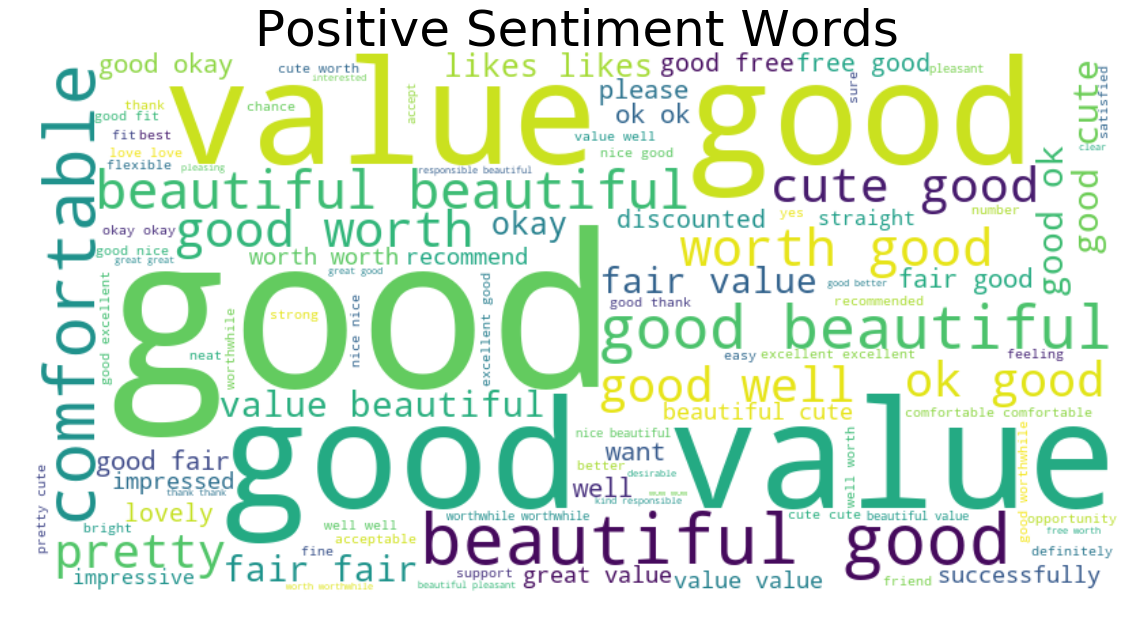

In [49]:
word_cloud_vis('', 'positive_words', "Positive Sentiment Words")

### Negative word clouds for whole dataset

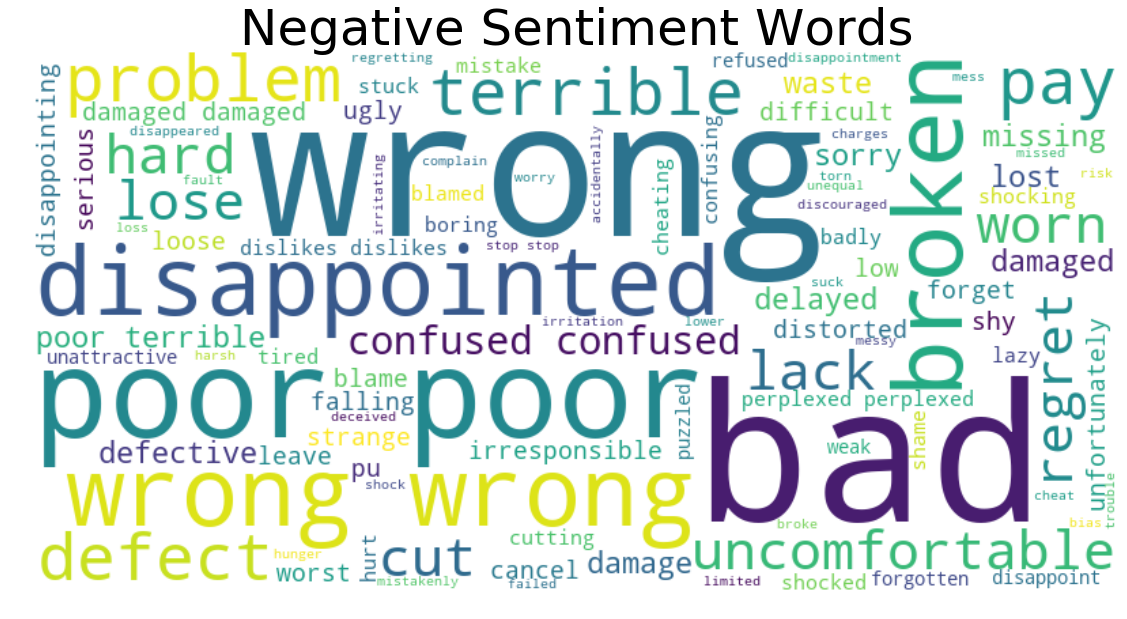

In [50]:
word_cloud_vis('', 'negative_words', "Negative Sentiment Words")

### Positive and Negative word clouds per category

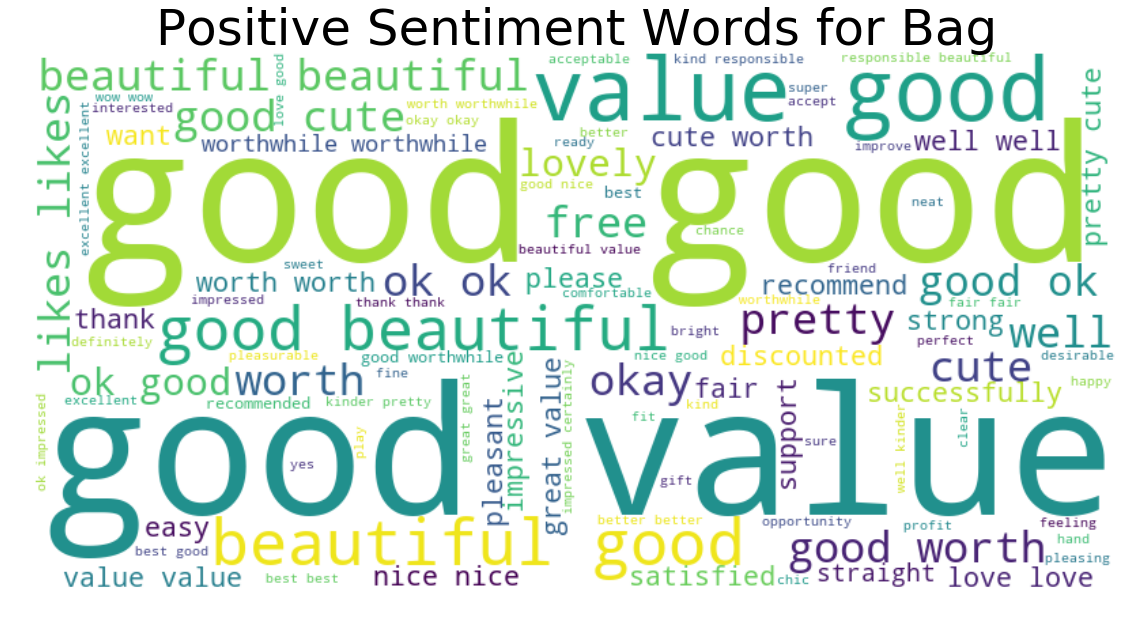

In [51]:
word_cloud_vis('Bag', 'positive_words', "Positive Sentiment Words for ")

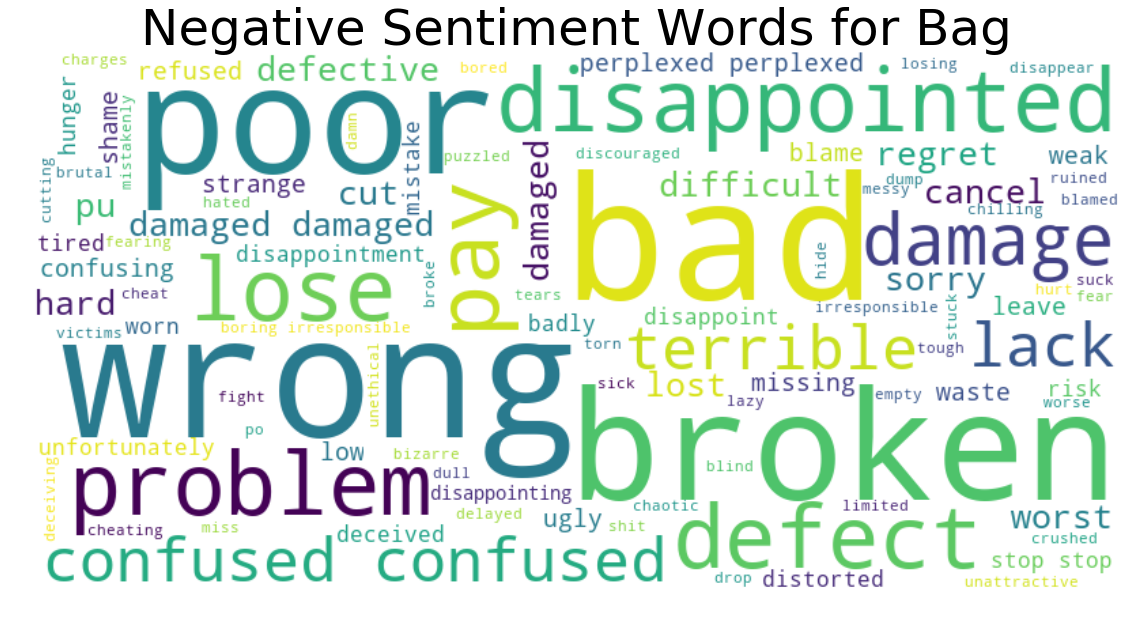

In [52]:
word_cloud_vis('Bag', 'negative_words', "Negative Sentiment Words for ")

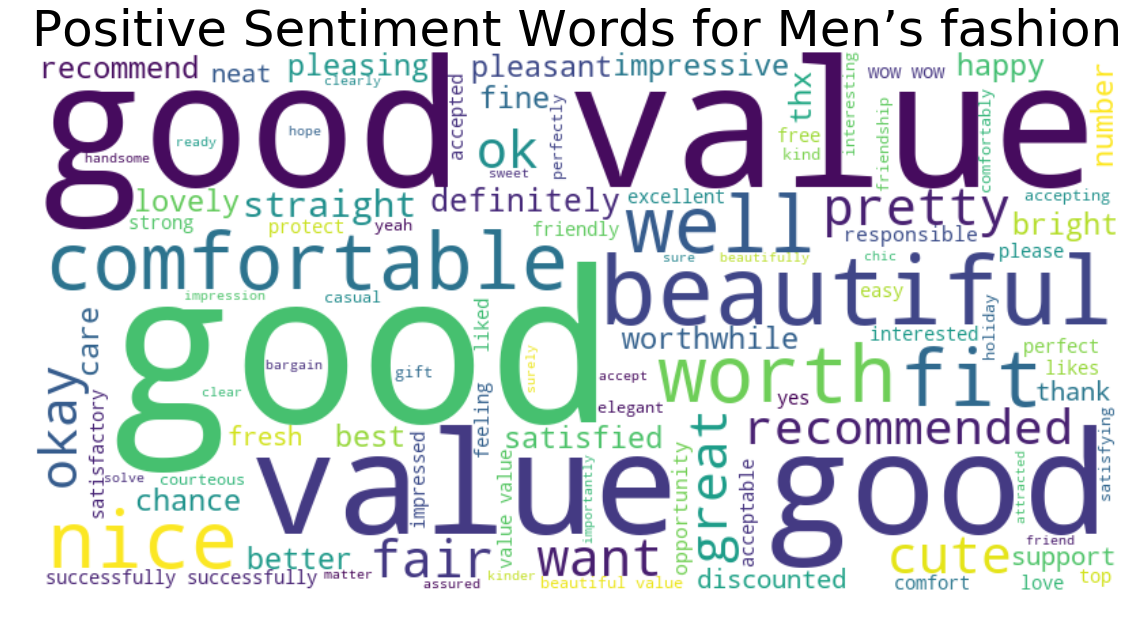

In [53]:
word_cloud_vis('Men’s fashion', 'positive_words', "Positive Sentiment Words for ")

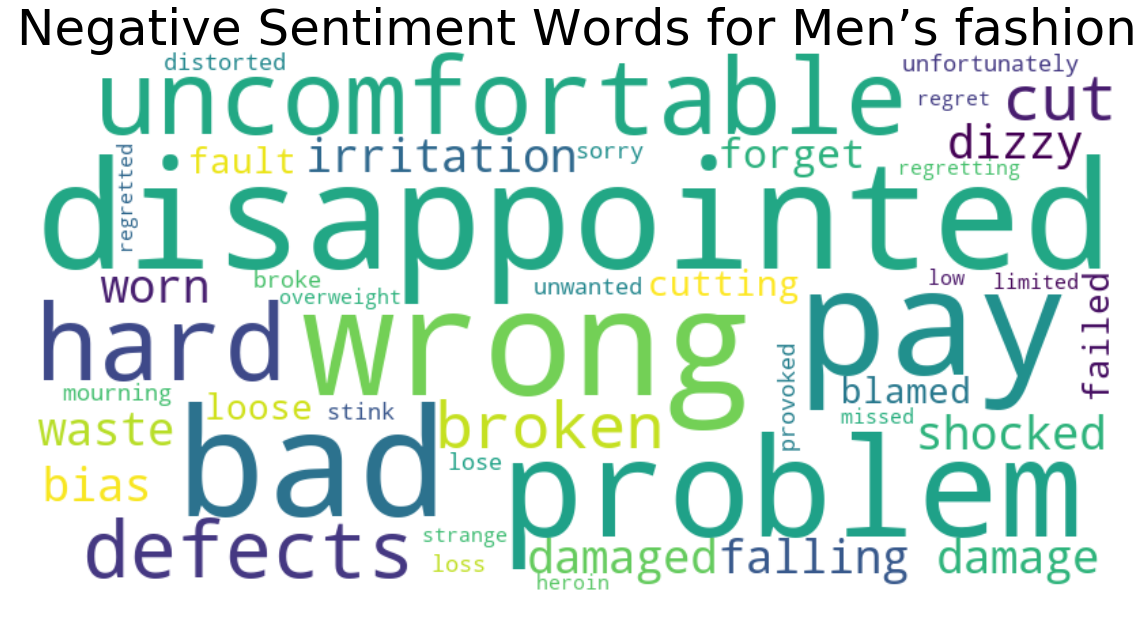

In [54]:
word_cloud_vis('Men’s fashion', 'negative_words', "Negative Sentiment Words for ")

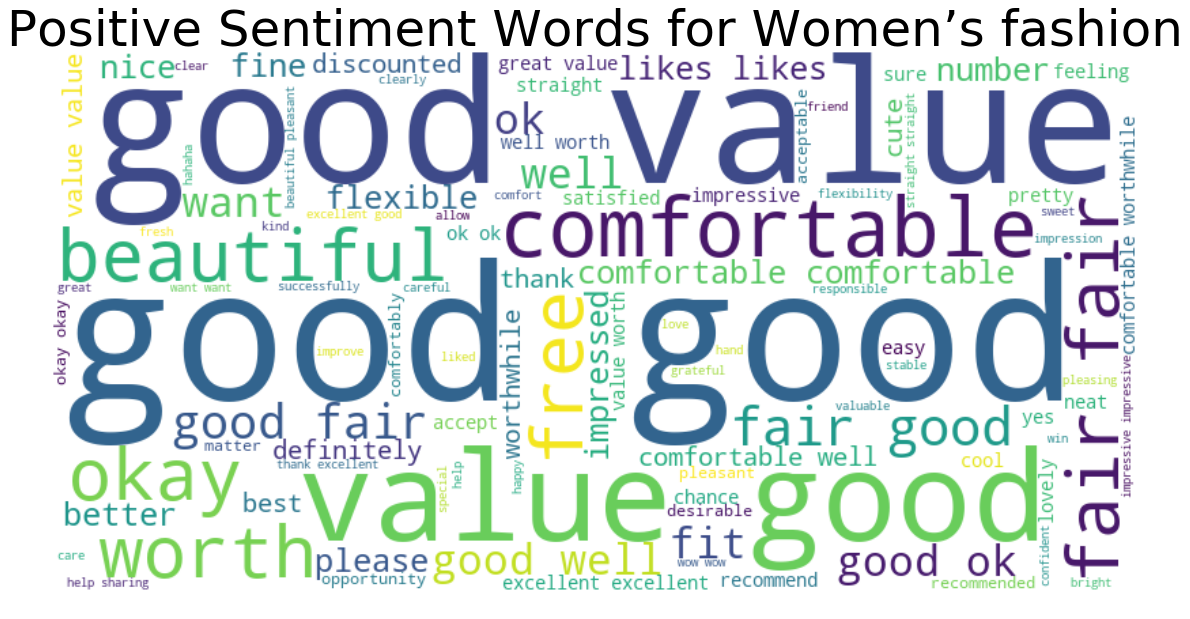

In [55]:
word_cloud_vis('Women’s fashion', 'positive_words', "Positive Sentiment Words for ")

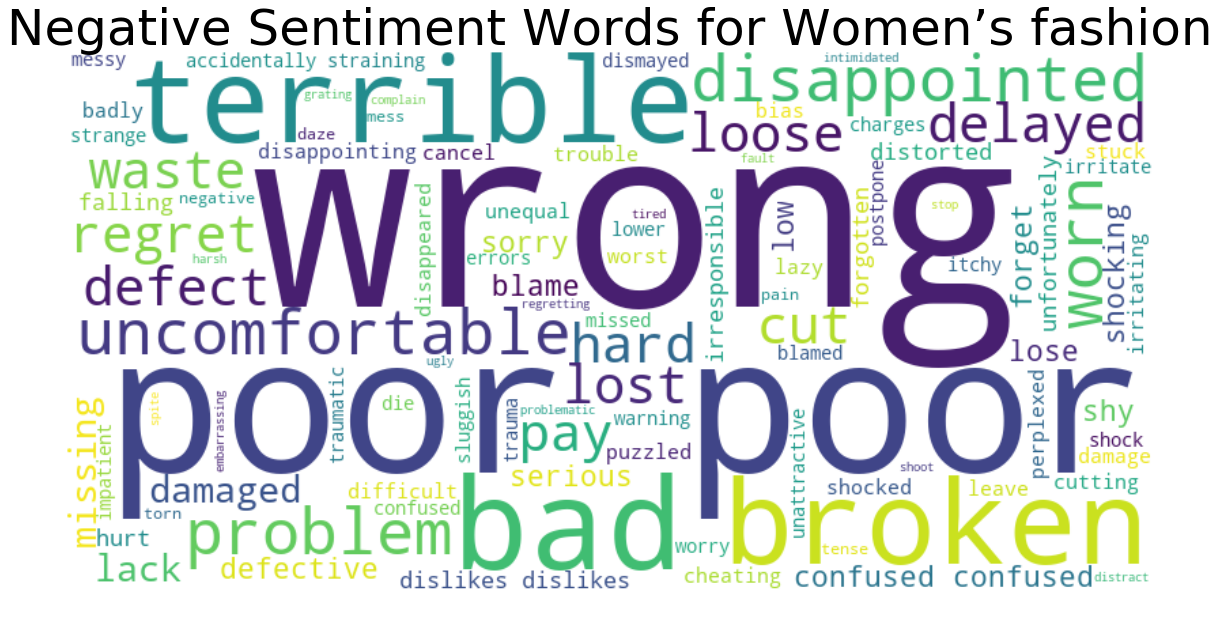

In [56]:
word_cloud_vis('Women’s fashion', 'negative_words', "Negative Sentiment Words for ")

### Aspect and opinion extraction
- Aspects are the important features rated by the reviewers
- Opinion words are the words which express opinion towards aspects
- In the aspect-based opinion mining, the aspect related opinion words should be identified
- The opinion words are mostly adjectives, the aspect words are nouns

### Dependency parser
-  It analyzes dependency paths in the syntactic tree of a review to find
- The selection and extraction is based on pairs of words or phrases called opinion pairs
- Extracting opinion pairs based on nouns and adjectives

In [57]:
from spacy.symbols import nsubj, VERB, dobj
from spacy import displacy

In [58]:
comment_doc = nlp(u"Great value Good product quality Great value")
displacy.render(comment_doc, style="dep", jupyter=True)

In [59]:
global_list = []
for token in comment_doc:
    text_list = []
    text_list.append(token.text)
    text_list.append(token.dep_)
    text_list.append(token.head.text)
    text_list.append(token.head.pos_)
    text_list.append([child for child in token.children])
    text_list.append(token.pos_)
    text_list.append([child for child in token.head.rights])
    text_list.append([child for child in token.head.lefts])
    
    global_list.append(text_list)
df_3 = pd.DataFrame(global_list, columns=["Text", "Dep", "Head text", "Head POS", "Children", "POS", 'rights', 'lefts'])    
df_3

Text       Dep Head text Head POS          Children   POS rights  \
0    Great      amod     value     NOUN                []   ADJ     []   
1    value  compound   quality     NOUN           [Great]  NOUN     []   
2     Good      amod   product     NOUN                []   ADJ     []   
3  product  compound   quality     NOUN            [Good]  NOUN     []   
4  quality  compound     value     NOUN  [value, product]  NOUN     []   
5    Great      amod     value     NOUN                []   ADJ     []   
6    value      ROOT     value     NOUN  [quality, Great]  NOUN     []   

              lefts  
0           [Great]  
1  [value, product]  
2            [Good]  
3  [value, product]  
4  [quality, Great]  
5  [quality, Great]  
6  [quality, Great]

In [60]:
def get_aspect_opinion(doc):
    def get_name(token):
        if (token.pos_ == 'PRON'):
            aspect = 'product'
        else:
            aspect = token.text 
        return aspect
    
    result = []
    for token in doc:
        if (token.pos_ in ('NOUN', 'PRON')) & (token.dep_ in ('ROOT', 'dobj', 'compound')):
            child_adj = [child.text for child in token.children if (child.pos_ == 'ADJ') | (child.dep_ == 'neg')]
            if len(child_adj) > 0:
                result.append(get_name(token) + ": " + ' '.join(child_adj))
        elif (token.pos_ in ('NOUN', 'PRON')) & (token.dep_ == 'nsubj'):
            right_adj = [right.text for right in token.head.rights if (right.pos_ == 'ADJ') | (right.dep_ == 'neg')]
            if len(right_adj) > 0:
                result.append(get_name(token) + ": " + ' '.join(right_adj))
            left_adj = [left.text for left in token.head.lefts if (left.pos_ == 'ADJ') | (left.dep_ == 'neg')]
            if len(left_adj) > 0:
                result.append(get_name(token) + ": " + ' '.join(left_adj))
            child_adj = [child.text for child in token.children if (child.pos_ == 'ADJ') | (child.dep_ == 'neg')]
            if len(child_adj) > 0:
                result.append(get_name(token) + ": " + ' '.join(child_adj))
        elif (token.pos_ == 'ADJ') & (token.head.pos_ == 'ADJ'):
            result.append("product: " + token.text)
    return '; '.join(result) if len(result) > 0 else ''

In [61]:
%%time
df['aspect_opinion'] = df[df['comments_lemma']!='']['comments_cleaned'].apply(lambda text: get_aspect_opinion(nlp(text)))

Wall time: 3min 57s


In [62]:
df['aspect_opinion'].fillna('',inplace=True)

In [63]:
len(df[df['aspect_opinion'] == ''])

1016

### Write results to excel
- save sentiment results in **Sentiment** column
- save aspect opinion results in **aspect_opinion** column

In [65]:
df[['title', 'rating', 'date', 'categorie', 'comments', 'sentiment', 'aspect_opinion']].to_csv(flags.output_file)

### Resources
- VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text

    http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
    
- Latent Dirichlet Allocation

    http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf